In [17]:
import sys
sys.path.append('../code')
sys.path.append('../')
import lfp_functions

import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import neo
import pandas as pd
from externals.SpectralEvents import spectralevents as se

In [40]:
experiment_dict = sio.loadmat('../data/SPK20220308/task_data/eventsCB1_corrected2.mat')
ev_ex = experiment_dict['eventsCB1']

downsample_rate = 30
samp_freq = 1000

#Use neo module to load blackrock files
fpath = '../data/SPK20220308/task_data/SPKRH20220308_CB1_quiver4toyPKPK4Rotation_delay_001'
lfp_data_raw, lfp_times_raw = lfp_functions.load_ns6_analog(fpath, downsample_rate, from_ns6=False, save=False, channel_step=2)

In [74]:
tgtON = ev_ex['tgtON_C'][0][0][0]
endhold = ev_ex['endhold_C'][0][0][0]

max_time = np.max(endhold - tgtON)
max_samples = int(max_time * samp_freq)
channel_idx = 50

lfp_data_list = list()
for tstart in tgtON:
    start_idx = np.argmin(np.abs(lfp_times_raw - tstart))
    stop_idx = start_idx + max_samples
    lfp_data_list.append(lfp_data_raw[channel_idx, start_idx:stop_idx])

lfp_data = np.stack(lfp_data_list)


In [4]:
downsample_rate = 30

#Use neo module to load blackrock files
fpath = '../data/SPK20220308/task_data/SPKRH20220308_CB1_quiver4toyPKPK4Rotation_delay_001'

lfp_data_raw, lfp_times_raw = lfp_functions.load_ns6_analog(fpath, downsample_rate, from_ns6=False, save=False, channel_step=2)

In [75]:
# set parameters
freqs = list(range(1, 60 + 1))   # fequency values (Hz) over which to calculate TFR
#times = np.arange(n_times) / samp_freq  # seconds
event_band = [13, 29]  # beta band (Hz)
thresh_FOM = 6.0  # factor-of-the-median threshold



In [82]:
times = np.linspace(0, lfp_data.shape[1] / samp_freq, lfp_data.shape[1])
tfrs = se.tfr(lfp_data[:50,:], freqs, samp_freq)


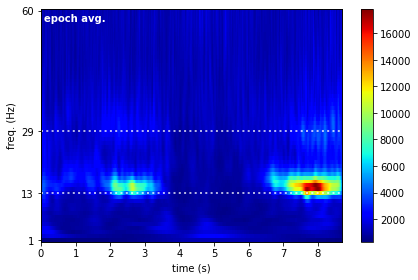

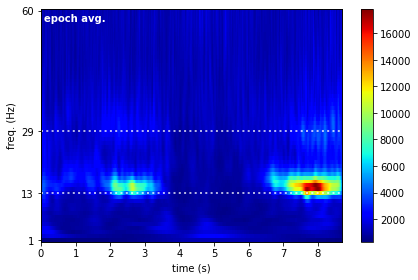

In [83]:
se.plot_avg_spectrogram(tfr=tfrs, times=times, freqs=freqs,
                              event_band=event_band, )



In [68]:
spec_events = se.find_events(tfr=tfrs, times=times, freqs=freqs,
                             event_band=event_band, threshold_FOM=thresh_FOM)

In [16]:
def get_beta_events(thisData, Fs, thisClassLabels):
    """
    thisData : 2d array (trials, time)
    Fs : sampling rate
    thisClassLabels : Numeric identifier for trial type, one for each trial in `this_data
    """

    eventBand = [15,29]      # Frequency range of spectral events
    fVec = np.arange(1,60+1)            # Vector of fequency values over which to calculate TFR
    #Fs = sampling_rate.copy()                            # Sampling rate of time-series
    findMethod = 1                      # Event-finding method (1 allows for maximal overlap while 2 limits overlap in each respective suprathreshold region)
    width = 7

    thrFOM = 6; #Factors of Median threshold (see Shin et al. eLife 2017 for details concerning this value)

    footprintFreq = 8
    footprintTime = 8
    threshold = 0.00
    neighbourhood_size = (footprintFreq,footprintTime)

    # Convert data to TFR 
    #thisData = lfp_data[:,0,:]
    #thisClassLabels = experiment_dict['grip']
    thisTFR, tVec, fVec = tse.spectralevents_ts2tfr( thisData.T, fVec, Fs, width )

    # Normalize the TFR data [tr x f x t] to the median value per frequency band 
    numTrials, numFreqBins, numSamples = thisTFR.shape
    TFR_order = np.transpose(thisTFR, axes=[1,0,2]) # [f x tr x t]
    TFR_reshape = np.reshape(TFR_order, (numFreqBins, numTrials*numSamples))
    TFRmeds = np.median(TFR_reshape, axis=1)        # f vector
    TFRmeds_expanded = np.transpose(np.tile(TFRmeds, (numSamples,numTrials,1)), axes=[1,2,0])
    thisTFR_norm = thisTFR/TFRmeds_expanded

    # Find local maxima in TFR
    thisSpecEvents = tse.spectralevents_find(findMethod, thrFOM, tVec, fVec, thisTFR, thisClassLabels, 
        neighbourhood_size, threshold, Fs)

    thisSpecEvents = pd.DataFrame(thisSpecEvents)
    thisSpecEvents = thisSpecEvents[np.logical_and(thisSpecEvents['Peak Frequency'] > 14, thisSpecEvents['Peak Frequency'] < 30)]
    thisSpecEvents = thisSpecEvents[thisSpecEvents['Outlier Event'] == True]

    return thisSpecEvents